Status: in progress

Remark: All the analysis is going to be aggregating all the data by hour, so doing it in that way, we can analyse all the years together and compare them

In [1]:
# packages 
import pandas as pd
import numpy as np

import missingno as msno 

from pymongo import MongoClient

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
sns.set_theme(style="ticks")

import sys
sys.path.append('/Users/ben_rss/Documents/CMM_2024/cmmProject/')


/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_25436/1677977105.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
## connecting
db_name = "meteo_paranal" # meteo_paranal_test, meteo_paranal

client = MongoClient("mongodb://localhost:27017/")
db = client[db_name] # meteo_paranal_test
collection = db[db_name]

## Counting Samples

In [3]:
print('Expected samples per year: ', 60*24*365) # asuming that we have un sample per minute

Expected samples per year:  525600


In [4]:
## samples per year
pipeline = [
    {   # it extracts the year from Date time
        "$project": { "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},}
    },
    { "$group": {# grouping by year and sum per sample 
            "_id": "$year",
            "count": {"$sum": 1}}
    },
    {"$sort": {"_id": 1}  # sort by year in ascending order
    }
]
result = list(collection.aggregate(pipeline))
for result_it in result:
    print(f"Year: {result_it['_id']}, Count: {result_it['count']}")

Year: 1998, Count: 369592
Year: 1999, Count: 506326
Year: 2000, Count: 518674
Year: 2001, Count: 508279
Year: 2002, Count: 512708
Year: 2003, Count: 514058
Year: 2004, Count: 517821
Year: 2005, Count: 514404
Year: 2006, Count: 516553
Year: 2007, Count: 496584
Year: 2008, Count: 497955
Year: 2009, Count: 456568
Year: 2010, Count: 447881
Year: 2011, Count: 505192
Year: 2012, Count: 508719
Year: 2013, Count: 493728
Year: 2014, Count: 422677
Year: 2015, Count: 417335
Year: 2016, Count: 519882
Year: 2017, Count: 520632
Year: 2018, Count: 523335
Year: 2019, Count: 524947
Year: 2020, Count: 526351
Year: 2021, Count: 524075
Year: 2022, Count: 524246
Year: 2023, Count: 525538
Year: 2024, Count: 23200


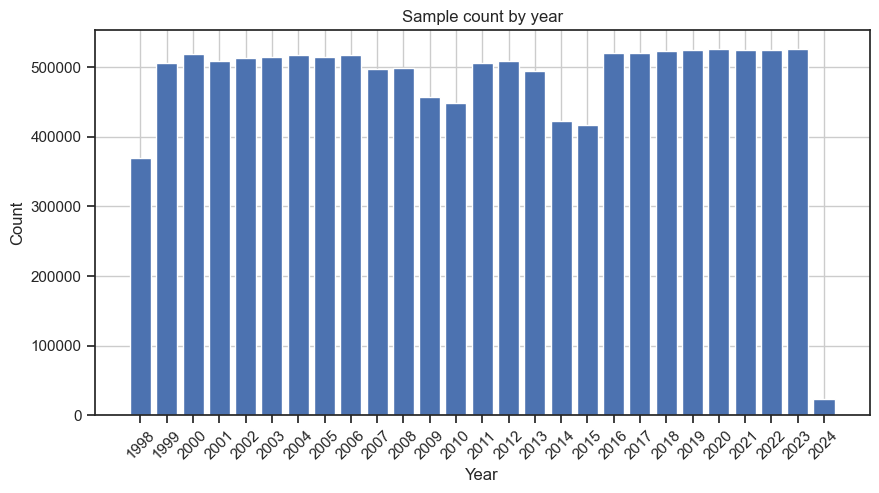

In [5]:
years = [result_it['_id'] for result_it in result]
counts = [result_it['count'] for result_it in result]

fig, ax = plt.subplots(figsize=(10,5))
plt.bar(years, counts)
plt.xticks(years,rotation=45)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Sample count by year')
plt.grid(True)
plt.show()

In [27]:
from utils.utils_columns import numeric_cols_paranal
numeric_cols_paranal # columns using

['Air Pressure at ground [hPa]',
 'Air Pressure Normalised [hPa]',
 'Air Temperature at 30m [C]',
 'Air Temperature at 2m [C]',
 'Air Temperature at ground [C]',
 'Air Temperature below VLT [C]',
 'Dew Temperature at 30m [C]',
 'Dew Temperature at 2m [C]',
 'Dew Temperature below VLT [C]',
 'Rain intensity below VLT [%]',
 'Relative Humidity at 30m [%]',
 'Relative Humidity at 2m [%]',
 'Relative Humidity below VLT [%]',
 'Wind Direction at 30m (0/360) [deg]',
 'Wind Direction at 30m (180/-180) [deg]',
 'Wind Direction at 10m (0/360) [deg]',
 'Wind Direction at 10m (180/-180) [deg]',
 'Wind Speed at 30m [m/s]',
 'Wind Speed at 10m [m/s]',
 'Wind Speed U at 20m [m/s]',
 'Wind Speed V at 20m [m/s]',
 'Wind Speed W at 20m [m/s]',
 'Air Pressure instantanous [hPa]',
 'Air Temperature instantanous at 30m [C]',
 'Air Temperature instantanous at 2m [C]',
 'Air Temperature instantanous at ground [C]',
 'Air Temperature instantaneous below VLT [C]',
 'Dew Temperature istantaneous at 30m [C]',
 

In [26]:
## utils functions (skip this cell)

def dict_to_datetime(x):
   return f"{x['year']}-{x['month']}-{x['day']} {x['hour']}:00:00"


def get_datetime_index(df):
    df['_id'] = pd.to_datetime(df['_id'].apply(dict_to_datetime))
    df = df.set_index(['_id'])
    df = df.sort_index(ascending=True)
    return df

def get_df(aggregated_expression):

    pipeline = [
        {"$group": {
                "_id": {
                    "year": {"$year": {"$dateFromString": {"dateString": "$Date time"}}},
                    "month": {"$month": {"$dateFromString": {"dateString": "$Date time"}}},
                    "day": {"$dayOfMonth": {"$dateFromString": {"dateString": "$Date time"}}},
                    "hour": {"$hour": {"$dateFromString": {"dateString": "$Date time"}}},
                }, 
                **aggregated_expression}},
        {"$sort": {"_id.year": 1, "_id.month": 1, "_id.day": 1, "_id.hour": 1} }
    ]

    result = list(collection.aggregate(pipeline))

    return pd.DataFrame(result)



Remark: that pipeline calculate the average per period only in the numeric values. Nan values are not considered:
https://www.mongodb.com/docs/manual/reference/operator/aggregation/avg/

In [7]:
## uploading data

# defining what we want
mean_agg = {f: {"$avg": f"${f}"} for f in numeric_col}
std_agg = {f: {"$stdDevSamp": f"${f}"} for f in numeric_col}
# min_agg = {f: {"$min": f"${f}"} for f in numeric_col}
# max_agg = {f: {"$max": f"${f}"} for f in numeric_col}

# getting df
df_mean = get_df(mean_agg)
df_std = get_df(std_agg)
# df_min = get_df(min_agg)
# df_max = get_df(max_agg)

# getting datetime index
df_mean = get_datetime_index(df_mean)
df_std = get_datetime_index(df_std)
# df_min = get_datetime_index(df_min)
# df_max = get_datetime_index(df_max)


In [40]:
df=df_mean.copy() # just for save
print('DF shape: ',df.shape)
display(df.head(3))

DF shape:  (218645, 49)


,Air Pressure at ground [hPa],Air Pressure Normalised [hPa],Air Temperature at 30m [C],Air Temperature at 2m [C],Air Temperature at ground [C],Air Temperature below VLT [C],Dew Temperature at 30m [C],Dew Temperature at 2m [C],Dew Temperature below VLT [C],Rain intensity below VLT [%],...,Wind Speed V instantanous at 20m [m/s],Wind Speed W instantanous at 20m [m/s],Particle (Large) at 20m [1/m^3],Particle (Large) at 10m [1/m^3],Particle (Small) at 20m [1/m^3],Particle (Small) at 10m [1/m^3],Particle (Large) Instantanous at 20m [1/m^3],Particle (Large) instantanous at 10m [1/m^3],Particle (Small) instantanous at 20m [1/m^3],Particle (Small) instantanous at 10m [1/m^3]
_id,,,,,,,,,,,,,,,,,,,,,
1998-07-19 18:00:00,743.227800,1025.033800,11.8068,12.630600,15.082000,NaN,-11.900000,-11.934600,NaN,NaN,...,NaN,NaN,436.860000,213.840000,22346.740000,21574.120000,NaN,NaN,NaN,NaN
1998-07-19 19:00:00,742.884000,1024.588333,11.4845,12.151167,15.479833,NaN,-11.908000,-12.398667,NaN,NaN,...,NaN,NaN,352.816667,209.400000,17865.550000,15795.816667,NaN,NaN,NaN,NaN
1998-07-19 20:00:00,743.166333,1024.955333,11.2140,11.778667,15.683000,NaN,-12.614167,-12.911500,NaN,NaN,...,NaN,NaN,494.283333,199.633333,20182.683333,15636.966667,NaN,NaN,NaN,NaN


In [9]:
# df.info()
# df.describe()

<Figure size 640x480 with 0 Axes>

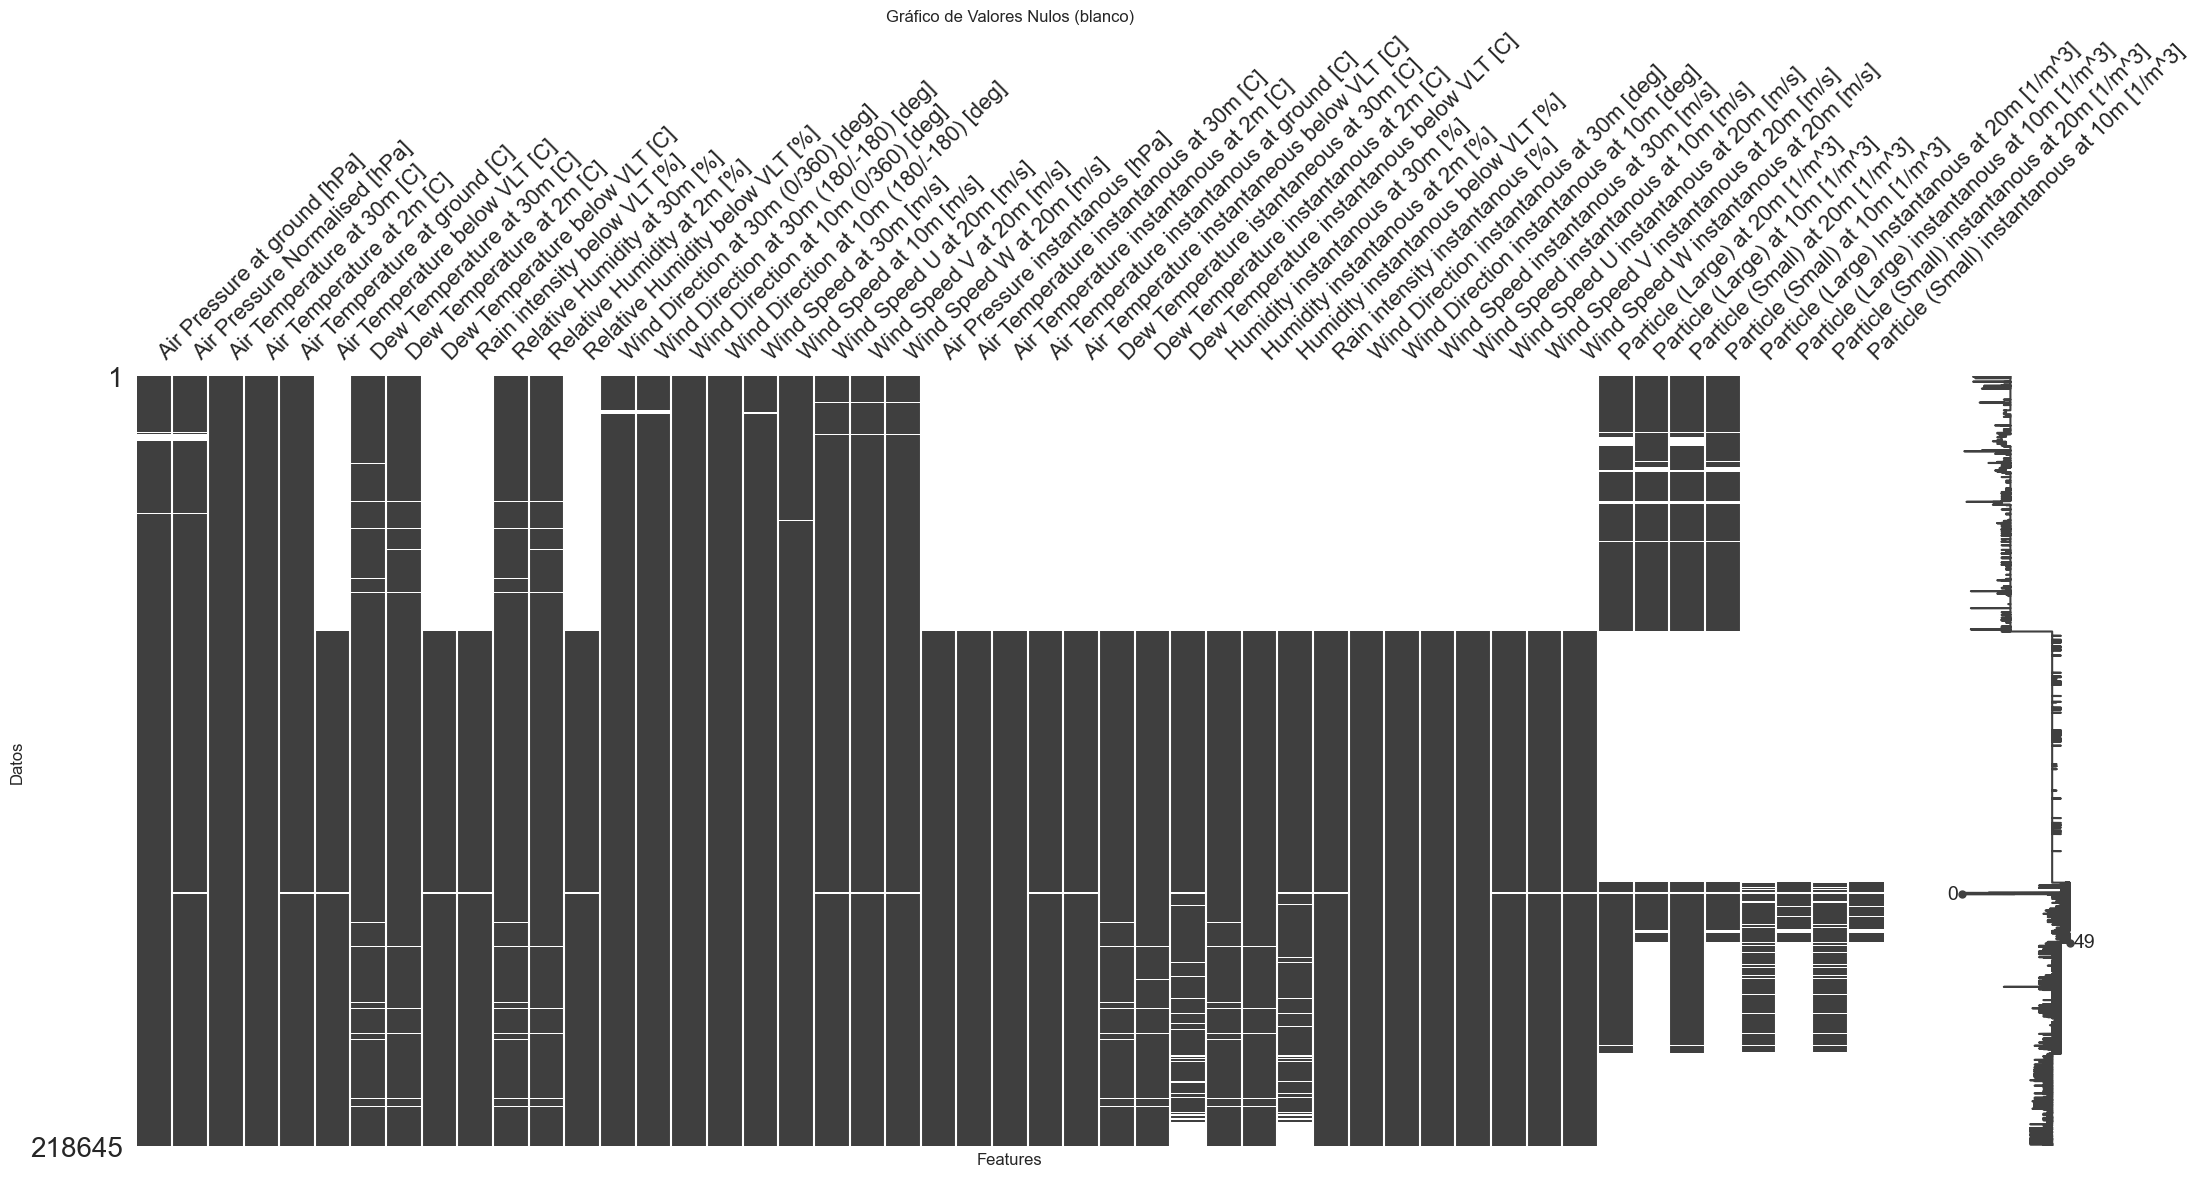

In [43]:
## general values of nan values
plt.clf()
msno.matrix(df)
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
# plt.gcf().set_size_inches(30, 25)
# plt.savefig("../plots/nullplot.png",dpi = 100)
plt.show()

In [11]:
## These are variables with mostly nan values
nan_columns =   [ 
   'Particle (Large) at 20m [1/m^3]',
   'Particle (Large) at 10m [1/m^3]',
   'Particle (Small) at 20m [1/m^3]',
   'Particle (Small) at 10m [1/m^3]',
   'Particle (Large) Instantanous at 20m [1/m^3]',
   'Particle (Large) instantanous at 10m [1/m^3]',
   'Particle (Small) instantanous at 20m [1/m^3]',
   'Particle (Small) instantanous at 10m [1/m^3]',]

<Figure size 640x480 with 0 Axes>

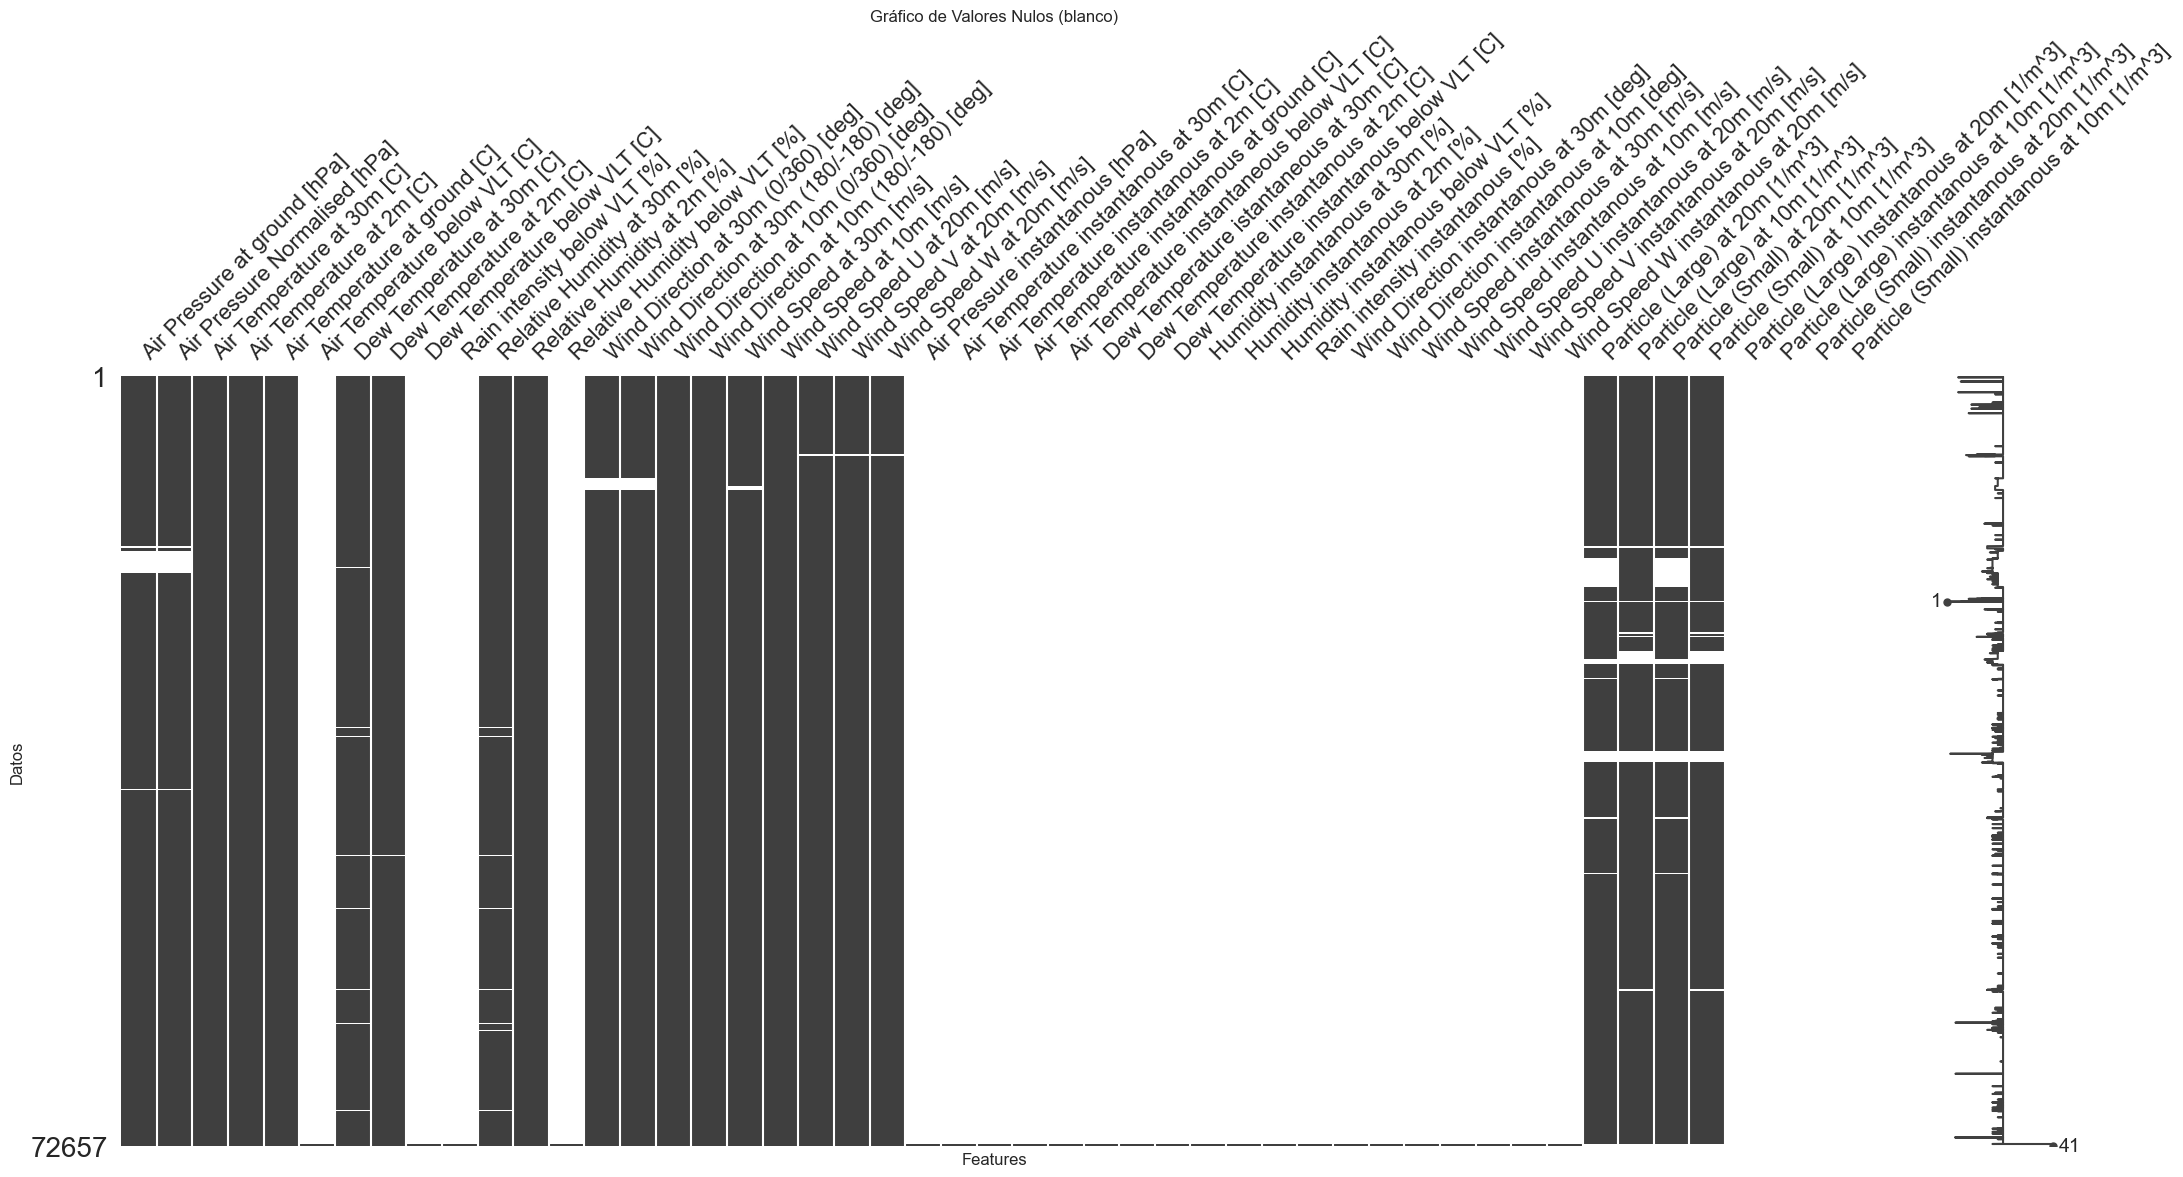

In [44]:
# plotting by dates
date_i = None
date_f =  '2007-01-10 12:00:00' #'2020-08-25 12:00:00'
plt.clf()
msno.matrix(df.loc[date_i:date_f])
plt.title('Gráfico de Valores Nulos (blanco)')
plt.xlabel('Features')
plt.ylabel('Datos')
# plt.savefig("../plots/nullsplot_date.png",dpi = 100)
plt.show()

In [13]:
# some variables where it started to appear null values
extra_cols = ['Air Pressure instantanous [hPa]',
 'Air Temperature instantanous at 30m [C]',
 'Air Temperature instantanous at 2m [C]',
 'Air Temperature instantanous at ground [C]',
 'Air Temperature instantaneous below VLT [C]',
 'Dew Temperature istantaneous at 30m [C]',
 'Dew Temperature instantanous at 2m [C]',]

In [14]:
## How it is looks nan values in extra_cols
df.loc['2006-12-31 10:00:00':'2006-12-31 14:00:00',extra_cols]
### 2006-12-31 12:00:00

,Air Pressure instantanous [hPa],Air Temperature instantanous at 30m [C],Air Temperature instantanous at 2m [C],Air Temperature instantanous at ground [C],Air Temperature instantaneous below VLT [C],Dew Temperature istantaneous at 30m [C],Dew Temperature instantanous at 2m [C]
_id,,,,,,,
2006-12-31 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-31 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-31 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-31 13:00:00,744.418333,16.850833,17.338333,19.563167,18.654500,-6.141667,-6.199500
2006-12-31 14:00:00,744.453333,17.144667,17.774833,19.443667,19.147667,-5.721667,-5.789333


* <= 2006-12-31 12:00:00 there is no data for some columns, these are for example in the variable "extra_cols".
Also if you check paranal samples in the endpoint, you can see there is nothing before to the corresponding variants of those columns. You can check these dates "2006-12-31..2007-01-01" selecting all fields. http://archive.eso.org/wdb/wdb/asm/meteo_paranal/form


In [48]:
# dropping what we won't use
df=df_mean.copy()
df = df.loc['2006-12-31 13:00:00':]
df = df.drop(columns=nan_columns,axis=1)
numeric_col = list(df.columns)

## Correlations

In [33]:
## correlation function
def get_principal_correlations(df_corr,n_display):

    upper_triangle_correlation = df_corr.where(np.triu(np.ones(df_corr.shape), k=1).astype(bool))
    top_positive_correlations = upper_triangle_correlation.unstack().sort_values(ascending=False)[:n_display]
    top_negative_correlations = upper_triangle_correlation.unstack().sort_values(ascending=True)[:n_display]

    rename_columns={'level_0':'feature1','level_1':'feature2',0:'Correlation'}

    less_correlated = upper_triangle_correlation.unstack().reset_index()
    less_correlated.rename(columns=rename_columns,inplace=True)
    less_correlated.Correlation=less_correlated.Correlation.apply(lambda x : abs(x))
    less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]

    top_positive_correlations=top_positive_correlations.reset_index()
    top_positive_correlations.rename(columns=rename_columns,inplace=True)

    top_negative_correlations=top_negative_correlations.reset_index()
    top_negative_correlations.rename(columns=rename_columns,inplace=True)


    return top_negative_correlations,top_positive_correlations,less_correlated

In [34]:
## getting principal correlations in excel format, located in corraltions/
top_negative_correlations,top_positive_correlations,less_correlated = get_principal_correlations(df.corr(),n_display=150)

/var/folders/b0/69vxpwp54bj58xqzl4ynkwbw0000gn/T/ipykernel_25436/678062977.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  less_correlated= less_correlated.sort_values(by=['Correlation'],ascending=True)[less_correlated['Correlation']>0][:n_display]


In [37]:
# display(top_negative_correlations)
# display(top_positive_correlations)
# display(less_correlated)
with pd.option_context('display.max_rows', None,):
    display(top_negative_correlations)
    display(top_positive_correlations)
    display(less_correlated)

,feature1,feature2,Correlation
0,Wind Speed W at 20m [m/s],Wind Speed U at 20m [m/s],-0.790362
1,Wind Speed U instantanous at 20m [m/s],Wind Speed W at 20m [m/s],-0.785736
2,Wind Speed W instantanous at 20m [m/s],Wind Speed U instantanous at 20m [m/s],-0.774999
3,Wind Speed W instantanous at 20m [m/s],Wind Speed U at 20m [m/s],-0.766227
4,Wind Speed V at 20m [m/s],Wind Direction at 30m (0/360) [deg],-0.621473
5,Wind Speed V instantanous at 20m [m/s],Wind Direction at 30m (0/360) [deg],-0.617305
6,Wind Direction instantanous at 10m [deg],Wind Speed V at 20m [m/s],-0.606710
7,Wind Speed V instantanous at 20m [m/s],Wind Direction instantanous at 10m [deg],-0.602892
8,Wind Direction instantanous at 30m [deg],Wind Speed V at 20m [m/s],-0.593842
9,Wind Speed V at 20m [m/s],Wind Direction at 10m (0/360) [deg],-0.593569


,feature1,feature2,Correlation
0,Rain intensity instantanous [%],Rain intensity below VLT [%],1.000000
1,Air Temperature instantanous at ground [C],Air Temperature at ground [C],0.999999
2,Air Temperature instantanous at 30m [C],Air Temperature at 30m [C],0.999997
3,Air Temperature instantanous at 2m [C],Air Temperature at 2m [C],0.999994
4,Dew Temperature instantanous at 2m [C],Dew Temperature at 2m [C],0.999990
5,Humidity instantanous below VLT [%],Relative Humidity below VLT [%],0.999980
6,Humidity instantanous at 2m [%],Relative Humidity at 2m [%],0.999979
7,Dew Temperature instantanous below VLT [C],Dew Temperature below VLT [C],0.999960
8,Air Temperature instantaneous below VLT [C],Air Temperature below VLT [C],0.999952
9,Dew Temperature istantaneous at 30m [C],Dew Temperature at 30m [C],0.999941


,feature1,feature2,Correlation
1189,Dew Temperature instantanous below VLT [C],Air Pressure at ground [hPa],0.000347
1424,Wind Direction instantanous at 30m [deg],Humidity instantanous at 30m [%],0.000796
1211,Dew Temperature instantanous below VLT [C],Air Pressure instantanous [hPa],0.000920
1404,Wind Direction instantanous at 30m [deg],Relative Humidity at 30m [%],0.001001
288,Dew Temperature at 2m [C],Air Pressure Normalised [hPa],0.001061
1149,Dew Temperature instantanous at 2m [C],Air Pressure Normalised [hPa],0.001431
287,Dew Temperature at 2m [C],Air Pressure at ground [hPa],0.002115
909,Air Pressure instantanous [hPa],Dew Temperature at 2m [C],0.002270
1148,Dew Temperature instantanous at 2m [C],Air Pressure at ground [hPa],0.002435
1170,Dew Temperature instantanous at 2m [C],Air Pressure instantanous [hPa],0.002557


# Plot Analysis

In [51]:
import holoviews as hv
from holoviews import opts
import hvplot.pandas

hv.extension('bokeh', 'matplotlib')

## Historic Histogram

* Folder: ../plots/historic_histograms/

In [52]:
# histogram per variables 
def create_histogram(variable):
    return df.hvplot.hist(y=variable, bins=200, title=f'Histogram of {variable}')

variables_list = numeric_col
histogram_dmap = hv.DynamicMap(create_histogram, kdims=['variable']).redim.values(variable=variables_list)
layout = histogram_dmap.opts(framewise=True)
layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'c737ba5d-dff5-4d5b-8820-d9e07efc5981': {'version…

In [19]:
### REMARK
# # Most stranges distributions:
# # 'Wind Direction at 30m (0/360) [deg]',----
# # 'Wind Direction at 30m (180/-180) [deg]',----
# # 'Wind Direction at 10m (0/360) [deg]',----
# # 'Wind Direction at 10m (180/-180) [deg]',----
# # 'Wind Direction instantanous at 30m [deg]',----
# # 'Wind Direction instantanous at 10m [deg]',----

# # Distributions which small range values:
# # 'Particle (Large) at 20m [1/m^3]',++
# # 'Particle (Large) at 10m [1/m^3]',++
# # 'Particle (Small) at 20m [1/m^3]',++
# # 'Particle (Small) at 10m [1/m^3]',++
# # 'Particle (Large) Instantanous at 20m [1/m^3]',++
# # 'Particle (Large) instantanous at 10m [1/m^3]',++
# # 'Particle (Small) instantanous at 20m [1/m^3]',++
# # 'Particle (Small) instantanous at 10m [1/m^3]'++
# # 'Wind Speed W at 20m [m/s]',++
# # 'Wind Speed W instantanous at 20m [m/s]',++

# # rest of them follow a distribution normal-like or log-normal

In [20]:
df_mean['Particle (Small) instantanous at 10m [1/m^3]'].describe() ## maybe for all of these features (refering to particle...) do a zoom in

count    1.455200e+04
mean     2.003910e+04
std      8.064640e+04
min      0.000000e+00
25%      9.333333e+00
50%      2.171667e+01
75%      1.916165e+03
max      6.073179e+06
Name: Particle (Small) instantanous at 10m [1/m^3], dtype: float64

## Histogram by year
* Folder: ../plots/histograms_per_year/

In [86]:
df['year'] = df.index.year
# histogram per variables 
def create_histogram(variable,year):
    return df[df.year==year].hvplot.hist(y=variable, bins=150, title=f'Histogram of {variable}')

variables_list = numeric_col
year_list = list(df.year.unique())
histogram_dmap = hv.DynamicMap(create_histogram, kdims=['variable','year']).redim.values(variable=variables_list,year = year_list)
layout = histogram_dmap.opts(framewise=True)
layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'97bb6924-0270-44ba-9897-7cfc6e9a7835': {'version…

In [ ]:
### REMARKS
# # Distributions which varies much per year
# # Air Temperature at ground [C]
# # Air Temperature below VLT [C]
# # Air Temperature instantaneous below VLT [C]',
# # Air Temperature instantanous at 2m [C]',
# # Air Temperature instantanous at 30m [C]
# # Air Temperature instantanous at ground [C]

# # 'Dew Temperature at 30m [C]',--
# # 'Dew Temperature at 2m [C]',--
# # 'Dew Temperature below VLT [C]',--
# # 'Dew Temperature istantaneous at 30m [C]',--
# # 'Dew Temperature instantanous at 2m [C]',--
# # 'Dew Temperature instantanous below VLT [C]',--
# # 'Humidity instantanous below VLT [%]'

# # 'Wind Direction at 30m (0/360) [deg]',----
# # 'Wind Direction at 30m (180/-180) [deg]',----
# # 'Wind Direction at 10m (0/360) [deg]',----
# # 'Wind Direction at 10m (180/-180) [deg]',----

## Scatterplot

In [ ]:
# Here I selected most interesting correlations I saw
# most correlated
pair1 = ('Humidity instantanous at 2m [%]',	'Dew Temperature instantanous at 2m [C]')
pair2 = ('Rain intensity instantanous [%]',	'Humidity instantanous at 2m [%]')
pair3 = ('Rain intensity instantanous [%]',	'Humidity instantanous at 30m [%]')

# less correlated
pair4 = ('Wind Speed V at 20m [m/s]',	'Air Temperature below VLT [C]')



In [103]:
def create_scatter(variable1, variable2):
    plot = hv.Scatter((df[variable1], df[variable2]))
    plot.opts(alpha=0.2,size = 1,title = "",xlabel = variable1,ylabel=variable2)
    return plot

variables_list = numeric_col
scatter_dmap = hv.DynamicMap(create_scatter, kdims=['variable1', 'variable2']).redim.values(variable1=variables_list, variable2=variables_list)
layout = scatter_dmap.opts(framewise=True,width=600, height=400)
layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'d04b8dc3-68cd-49be-b827-c696b71a1c7f': {'version…

In [110]:
def create_scatter(year,variable1, variable2):
    plot = hv.Scatter((df[df.year==year][variable1], df[df.year==year][variable2]))
    plot.opts(size = 1,title = "",xlabel = variable1,ylabel=variable2)
    return plot

variables_list = numeric_col
scatter_dmap = hv.DynamicMap(create_scatter, kdims=['year','variable1', 'variable2']).redim.values(year=list(df.year.unique()),
                                                                                                   variable1=variables_list, 
                                                                                                   variable2=variables_list)
layout = scatter_dmap.opts(framewise=True,width=600, height=400)
layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'52ff2624-c09f-4a49-95d6-662d4bd74331': {'version…

* pair1 interesting

## time series subplots

In [108]:
def create_scatter(year, variable1):
    plot = hv.Scatter((df[df.year==year].index, df[df.year==year][variable1]))
    plot.opts(size = 2,title = "",xlabel = "time",ylabel=variable1)
    return plot

variables_list = numeric_col
scatter_dmap = hv.DynamicMap(create_scatter, kdims=['variable1', 'year']).redim.values(variable1=variables_list, year=list(df.year.unique()))
layout = scatter_dmap.opts(framewise=True,width=800, height=400)
layout

BokehModel(combine_events=True, render_bundle={'docs_json': {'c8811c1e-7685-4c2a-8994-d62bd6cd5747': {'version…

Variables which shows frequency insteresting in the first touch
* Air Temperature at ground [C] 
* Air Temperature instantaneous below VLT [C]
* All Dew temperature
* humidity: tends to get high in first semester of every year
*  "wind directions" variables shows a lot of variance over all year without any pattern 

### Next steps
* see variables periodicity by season, night/day
* see variables at differents levels (i.e. ground, 2m, 10m, 20m, etc)
* what we find if we apply clusterization
* do the same but with different aggregation, here we did it with 1 hour, doing it with 15 min would be more accurate